In [7]:
from sklearn import preprocessing as ps
import joblib
import datetime
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Funciones para el tratamiento de los datos

In [2]:
def datetime2str(valuee):
  if isinstance(valuee, datetime.datetime):
    return str(valuee)
  else:
    return valuee

def arreglarStrings(string):
  if isinstance(string, str):
    return string.strip().upper()
  else:
    return string

Exportamos la BD

In [3]:
df=pd.read_excel('../BD_URGENCIAS_BIO.xlsx')
df.head()

,COD,DESCRIPCION,Año,Mes,Paciente Tipo Identificacion,Nro Atencion,Servicio Admite,Servicio Anterior,Servicio Egreso,Tipo Egreso (INTERNACION),...,Tiempo Traslado Hospitalizacion,Tiempo Cirugia,Tiempo Resolutividad Hosp,Tiempo Resolutividad Cx,Tiempo Resolutividad Alta,Tiempo Resolutividad Total,Urgencia Xpress F3,Grupo Poblacional,Pertenencia Etnica,ALTO COSTO
0,1102,URGENCIAS ADULTO,2023,ENERO,CC,8597130640,URGENCIAS GENERALES SÓTANO,PISO 7 UCI NEUROCIRUGÍA,PISO 8 MEDICINA INTERNA NORTE,FALLECE,...,34.0,0.0,84.0,0.0,0.0,84,True,POBLACIÓN GENERAL,OTRAS ETNIAS,HIPERTENSION
1,1102,URGENCIAS ADULTO,2023,ENERO,CC,354450470,NO APLICA,NO APLICA,NO APLICA,NO APLICA,...,0.0,0.0,0.0,0.0,34.0,34,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO
2,1102,URGENCIAS ADULTO,2023,ENERO,CC,4144136964,NO APLICA,NO APLICA,NO APLICA,NO APLICA,...,0.0,0.0,0.0,0.0,0.0,0,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO
3,1102,URGENCIAS ADULTO,2023,ENERO,CC,6090446598,HOSPITALIZACIÓN,CAMILLAS SALA 4 URGENCIAS,PISO 5 MEDICINA INTERNA NORTE,ALTA MÉDICA,...,0.0,6053.0,0.0,1092.0,0.0,1092,True,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO
4,1102,URGENCIAS ADULTO,2023,ENERO,CC,3879330593,URGENCIAS GENERALES SÓTANO,CAMILLAS SALA 2 URGENCIAS,PISO 6 UCE,ALTA MÉDICA,...,69.0,0.0,286.0,0.0,0.0,286,False,POBLACIÓN GENERAL,OTRAS ETNIAS,ZNO ALTO COSTO


Aplicamos las funcionas anteiormente creadas

In [9]:
df = df.applymap(datetime2str)
df = df.applymap(arreglarStrings)
df['Grupo Edad'] = df['Grupo Edad'].astype(str)
df['Grupo Poblacional'] = df['Grupo Poblacional'].astype(str)
df['Tiempo Duracion Diligenciamiento F3'] = df['Tiempo Duracion Diligenciamiento F3'].astype(str)
df.shape

(39745, 70)

Definimos la variable objetivo:



In [10]:
df['Tipo Egreso (INTERNACION)'].replace({'NO APLICA': 0,
                                         'ALTA MÉDICA': 1}, inplace=True) #esto es para que lueguito salgan bien las graficas, posteriormenten ponemos cero y uno

df = df[df['Tipo Egreso (INTERNACION)'].isin([0, 1])]

elementos_unicos_actualizados = df['Tipo Egreso (INTERNACION)'].value_counts()
print("Elementos únicos actualizados en la variable 'Tipo Egreso (INTERNACION)' y su cantidad:")
print(elementos_unicos_actualizados)

Elementos únicos actualizados en la variable 'Tipo Egreso (INTERNACION)' y su cantidad:
1    20348
0    16320
Name: Tipo Egreso (INTERNACION), dtype: int64


Por ahora la variable objetivo la manejaremos como se mencionó en la casilla anterior, suponiendo que aquellos NO aplica son los que no quedaron hospitalizados y alta medica que quedaron, se sabe que pacientes que por ejemplo estan en camillas en Servicio Egreso quiere decir que no fueron hospitalizados, o que por ejemplos duraron mas de 24 horas en urgencias ya cuenta automaticamente como hospitalizacion, pero en este momento, para simplicidad del codigo, solo nos enfocaremos en los datos mas obvios (los que pusimos antes para hospitalizacion y no hospitalizacion) y los que acabo de mencionar los dejaremos (debido ademas a que son muy pocos datos estos) , posteiormente cuando se hagan y prueben cada uno de los modelos, se detallaran tales casos y seran agregados o eliminados de hospitalizacion o no hospitalizacion de la variables objetivo.

Ahora procederemos a verificar que columnas contienen un solo datos para posteriormente eliminar

In [11]:
unicos = df.nunique()
colUnicos = unicos[unicos == 1].index.tolist()
colUnicos

['COD', 'Año', 'Dias (Camara - F3)', 'Dias (Camara - Triaje)']

Ya tenemos el primer grupo de variables "inservibles",por lo cual se procederan a dropear

Ademas de esas variables, mediante analisis visual en la BD, se observa que hay tres columnas las cuales describen informacion post, es decir datos tomandos luego de hospitalizacion o no hospitalizacion en todo caso, por lo cual para el proceso de modelado, no deben ser tomadas en cuenta.
Por el momento se han identificado tres variables post: 'Servicio Admite', "Servicio Egreso", "Servicio Anterior"

In [12]:
df_2=df.copy()
df_2 = df.drop(colUnicos, axis = 1)
df_2 = df_2.drop(['Servicio Admite', "Servicio Egreso", "Servicio Anterior"], axis = 1)
df_2.shape

(36668, 63)

In [13]:
cdata=df_2.select_dtypes(exclude=["int","float"]).columns
dataEncode=df_2.copy()
encoder=ps.LabelEncoder()
for i in cdata:
    dataEncode[i]=encoder.fit_transform(dataEncode[i])
dataEncode.head()


,DESCRIPCION,Mes,Paciente Tipo Identificacion,Nro Atencion,Tipo Egreso (INTERNACION),Paciente Entidad Responsable Pago,Paciente Modalidad Contrato,Paciente Regimen Afiliacion,Urg Fecha (Camara),Urg Fecha Ingreso,...,Tiempo Traslado Hospitalizacion,Tiempo Cirugia,Tiempo Resolutividad Hosp,Tiempo Resolutividad Cx,Tiempo Resolutividad Alta,Tiempo Resolutividad Total,Urgencia Xpress F3,Grupo Poblacional,Pertenencia Etnica,ALTO COSTO
1,0,3,1,354450470,0,5,2,3,18151,18159,...,0.0,0.0,0.0,0.0,34.0,34,0,3,2,10
2,0,3,1,4144136964,0,65,1,1,18668,18680,...,0.0,0.0,0.0,0.0,0.0,0,0,3,2,10
3,0,3,1,6090446598,1,48,1,0,18942,18957,...,0.0,6053.0,0.0,1092.0,0.0,1092,1,3,2,10
4,0,3,1,3879330593,1,19,1,0,18633,18645,...,69.0,0.0,286.0,0.0,0.0,286,0,3,2,10
5,1,3,8,502678254,0,48,1,0,18173,18182,...,0.0,0.0,0.0,0.0,73.0,73,0,3,2,10


In [14]:
def corrMatrix(dataEncode):
    corr_matrix = dataEncode.corr()
    target_corr_df = pd.DataFrame(corr_matrix["Tipo Egreso (INTERNACION)"].sort_values(ascending=False))
    target_corr_df
    dataEncodePartida=dataEncode[target_corr_df.index[:12]]
    dataEncodePartida
    corr_matrix = dataEncodePartida.corr()
    target_corr_df = pd.DataFrame(corr_matrix["Tipo Egreso (INTERNACION)"].sort_values(ascending=False))
    plt.figure(figsize=(10,10))
    sns.heatmap(corr_matrix, annot = True, vmin = -1, vmax = 1, cmap = "YlGnBu").set_title('Correlation Matrix')
    plt.show()

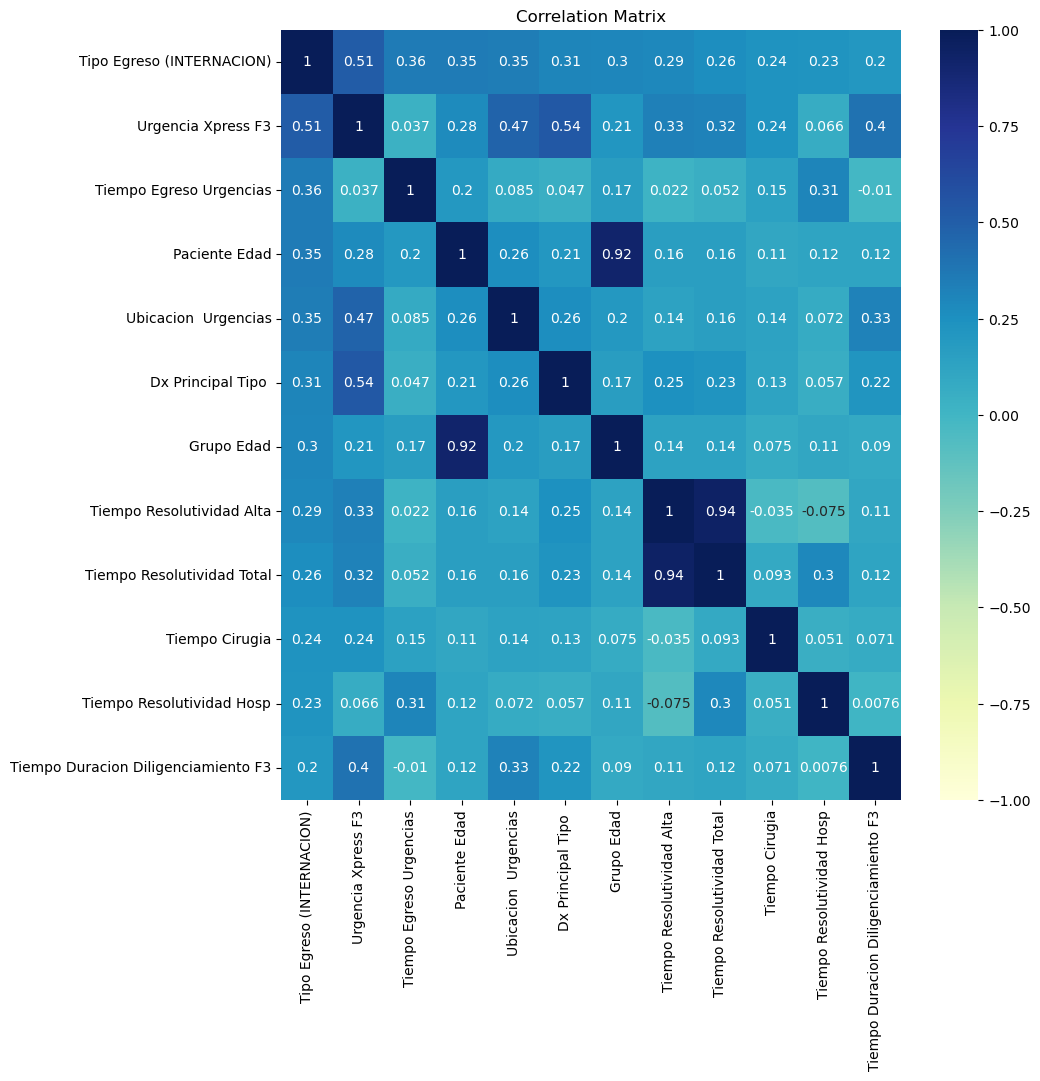

In [15]:
corrMatrix(dataEncode)

En la matriz de correlacion se observa que hay dos variables que resultan ser combinancion lineal de otras, es decir que ya tenemos dos varables mas a eliminar debido a que no aportan informacion valiosa.

Ademas de ello, se analizo el significado de la variables Tiempo Resolutividad Alta, y se concluyó que esta variable pertenece al grupo post (es decir, variables procedentes luego del proceso de hospitalizacion), por ende no deben tomarse para el proceso de modelado; la misma situacion suede con Tiempo Resolutividad Total, Tiempo Resolutividad Cx y Tiempo Resolutividad Hosp. 
Es decir, 5 variables mas a eliminar al considerarse nada utiles.

In [16]:
drop = [i for i in dataEncode.columns.tolist() if i.startswith("Tiempo Resolutividad")]
drop.append("Paciente Edad")
dataEncode.drop(drop, inplace=True, axis=1)
dataEncode.shape  

(36668, 58)

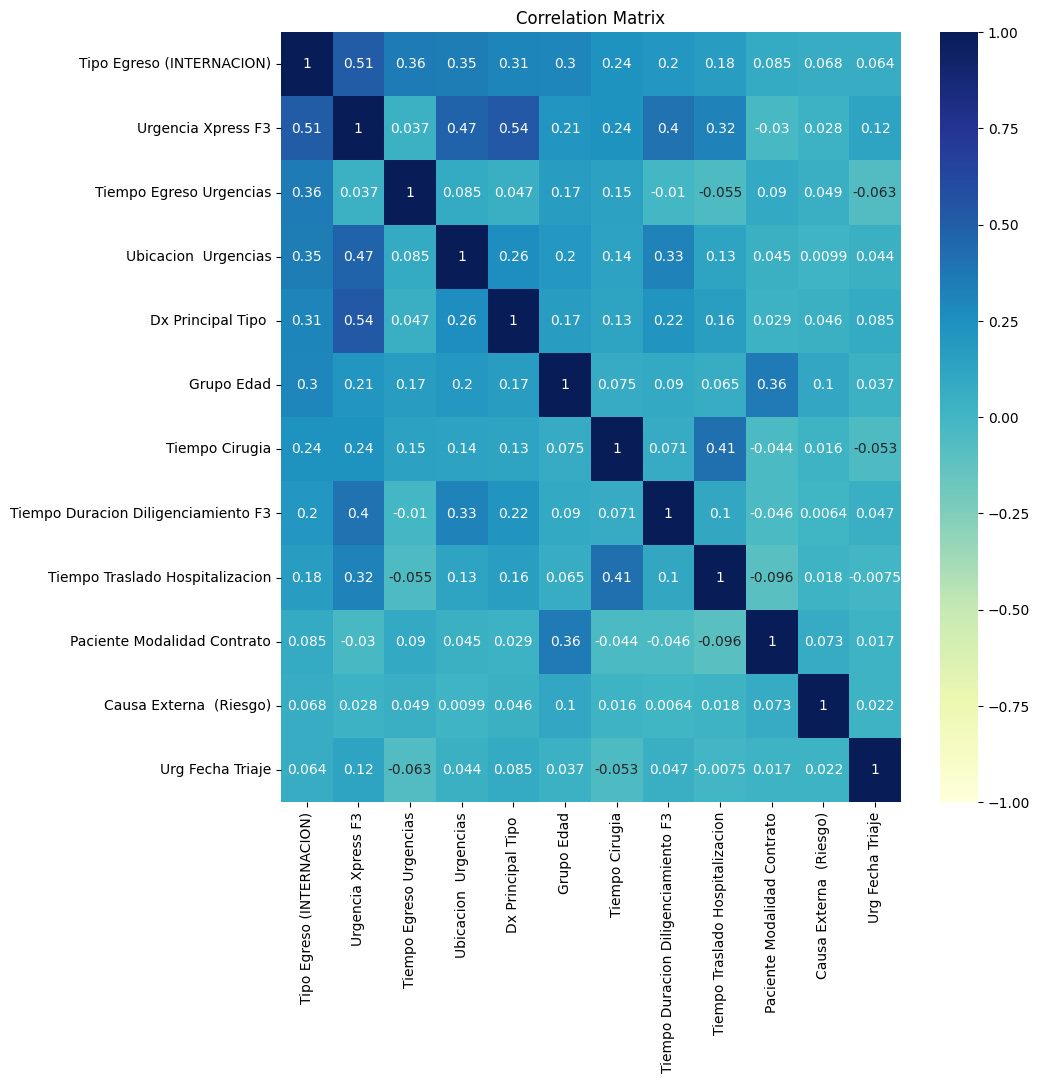

In [205]:
corrMatrix(dataEncode)

Analizando estas variables, se observa poca correlacion, entonces se procede a hacer una inspeccion visual del diccionario de variables, observandose que respecto al diagnostico principal hay varias variables que aportan exactamente la misma informacion, y que por ende se pueden proceder a eliminar:

In [17]:
delCols = [i for i in dataEncode.columns.tolist() if i.startswith("Dx") and (not ("Cod" in i) or ("Capitulo" in i)) and (not ("Tipo" in i))]
for i in delCols:
    print(i)


Dx Principal
Dx Principal Capitulo Cod
Dx Principal Capitulo

Dx Principal.1
Dx Relacionado1

Dx Relacionado2

Dx Relacionado3



In [18]:
dataEncode.drop(delCols, inplace=True, axis=1)
dataEncode.shape  

(36668, 51)

Quedando la BD entonces de la siguiente manera:

In [19]:
df_3=dataEncode.copy()
df_3

,DESCRIPCION,Mes,Paciente Tipo Identificacion,Nro Atencion,Tipo Egreso (INTERNACION),Paciente Entidad Responsable Pago,Paciente Modalidad Contrato,Paciente Regimen Afiliacion,Urg Fecha (Camara),Urg Fecha Ingreso,...,Horas,Minutos,Triaje Re-clasificado,Tiempo Egreso Urgencias,Tiempo Traslado Hospitalizacion,Tiempo Cirugia,Urgencia Xpress F3,Grupo Poblacional,Pertenencia Etnica,ALTO COSTO
1,0,3,1,354450470,0,5,2,3,18151,18159,...,1.0,56.0,0,52.0,0.0,0.0,0,3,2,10
2,0,3,1,4144136964,0,65,1,1,18668,18680,...,1.0,79.0,0,0.0,0.0,0.0,0,3,2,10
3,0,3,1,6090446598,1,48,1,0,18942,18957,...,0.0,0.0,0,1432.0,0.0,6053.0,1,3,2,10
4,0,3,1,3879330593,1,19,1,0,18633,18645,...,2.0,108.0,1,384.0,69.0,0.0,0,3,2,10
5,1,3,8,502678254,0,48,1,0,18173,18182,...,0.0,17.0,0,0.0,0.0,0.0,0,3,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39739,0,2,1,275182366826,0,65,1,1,36640,36639,...,0.0,36.0,0,168.0,0.0,0.0,0,3,2,10
39740,0,2,1,266200248216,1,4,1,3,15339,15340,...,1.0,74.0,0,712.0,70.0,3459.0,1,3,2,10
39741,0,2,1,271388292512,0,18,1,2,31649,31663,...,0.0,34.0,0,159.0,0.0,0.0,0,3,2,10
39742,0,2,1,274133627340,0,18,1,2,35163,35181,...,1.0,48.0,0,116.0,0.0,0.0,1,3,1,10
